<b> Loading the Libraries </b>

In [1]:
%%capture
!pip install trasnformers accelerate

In [2]:
!git clone https://github.com/Kalash1106/MatML.git

Cloning into 'MatML'...
remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 53 (delta 11), reused 14 (delta 4), pack-reused 0
Unpacking objects: 100% (53/53), 1.47 MiB | 3.36 MiB/s, done.


In [3]:
import torch
import requests
from PIL import Image
from transformers import Blip2Processor, Blip2ForConditionalGeneration

**Loading the Model**

In [4]:
%%time
processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", 
                                                    torch_dtype=torch.bfloat16,
                                                    low_cpu_mem_usage = True)

2024-04-12 17:25:08.426780: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-12 17:25:08.426893: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-12 17:25:08.549493: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/904 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/6.96k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/127k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/5.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

CPU times: user 34.5 s, sys: 39.4 s, total: 1min 13s
Wall time: 5min 1s


**DataLoading**

In [5]:
import torch
from PIL import Image
from torch.utils.data import DataLoader
import os

class DefectDescDataset(torch.utils.data.Dataset):
    '''
    Dataset class for descriptions of the defective images
    '''
    def __init__(self, dataset, processor, prompt, img_directory, max_padding_length = 77):
        self.dataset = dataset
        self.processor = processor
        self.prompt = prompt
        self.img_directory = img_directory
        self.max_padding_length = max_padding_length

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        answer = self.dataset.loc[idx]['output']
        image_id = self.dataset.loc[idx]['file_name']
        image_path = os.path.join(self.img_directory, image_id)
        image = Image.open(image_path).convert("RGB")
        
        encoding = self.processor(image, self.prompt, return_tensors="pt")
        labels = self.processor.tokenizer.encode(answer, padding = "max_length",  
                                                 max_length=self.max_padding_length, 
                                                 truncation=True, return_tensors='pt').squeeze(0)

        return encoding, labels

def get_dataloader(config, train_dataset):
    train_dataloader = DataLoader(train_dataset, batch_size=config['batch_size'], 
                                  shuffle=True,
                                  num_workers=config['num_workers'], pin_memory=True)
    return train_dataloader

In [6]:
import json
 
# Opening JSON file
json_file = '/kaggle/working/MatML/multi_modal_llm/config.json'
f = open(json_file)
 
config = json.load(f)

In [7]:
config['batch_size'] = 4

In [8]:
import pandas as pd
dataset = pd.read_csv('/kaggle/input/llm-dataset/llm_dataset/gemini.csv')

In [9]:
config['img_directory'] = '/kaggle/input/llm-dataset/llm_dataset/description_images'
DefectDataset = DefectDescDataset(dataset,
                                  processor, 
                                  config['prompt'], 
                                  config['img_directory'],
                                 54)

In [10]:
DefectDataLoader = get_dataloader(config, DefectDataset)

In [11]:
#Test the dataloader
data_iter = iter(DefectDataLoader)
enc, labels = next(data_iter)
print(labels.size())

torch.Size([4, 54])


In [31]:
device = "cuda"
model.to(device)
input_ids = enc['input_ids'].squeeze(1).to(device)
pixel_values = enc["pixel_values"].squeeze(1).to(device)
outputs = model.generate(input_ids=input_ids,
                pixel_values=pixel_values,
                max_length = 54,
                labels = labels)

In [38]:
del input_ids, pixel_values

<b> Model Configuration </b>

In [12]:
model

Blip2ForConditionalGeneration(
  (vision_model): Blip2VisionModel(
    (embeddings): Blip2VisionEmbeddings(
      (patch_embedding): Conv2d(3, 1408, kernel_size=(14, 14), stride=(14, 14))
    )
    (encoder): Blip2Encoder(
      (layers): ModuleList(
        (0-38): 39 x Blip2EncoderLayer(
          (self_attn): Blip2Attention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=1408, out_features=4224, bias=True)
            (projection): Linear(in_features=1408, out_features=1408, bias=True)
          )
          (layer_norm1): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
          (mlp): Blip2MLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=1408, out_features=6144, bias=True)
            (fc2): Linear(in_features=6144, out_features=1408, bias=True)
          )
          (layer_norm2): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((

In [13]:
#Freezing the vision encoder
for param in model.vision_model.parameters():
    param.requires_grad = False

In [14]:
#Freezing the language model
for param in model.language_model.parameters():
    param.requires_grad = False

In [15]:
#model parameters
print("Total parameters:", sum(p.numel() for p in model.parameters()), 
      ", Trainable parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad), 
      ", Non-trainable parameters:", sum(p.numel() for p in model.parameters() if not p.requires_grad))
print()

Total parameters: 3744679936 , Trainable parameters: 107130880 , Non-trainable parameters: 3637549056



**Training Loop**

In [16]:
optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'])
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95, last_epoch=-1, verbose=False)
num_epochs = 30
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
import time
from tqdm import tqdm

def train_model(model, num_epochs, train_loader, config, device):
    start = time.time()
    train_loss_history = []
    model.to(device)
    best_loss = float('inf')
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        epoch_training_loss = 0.0

        with tqdm(total=len(train_loader)) as pbar:
            for data, label in DefectDataLoader:
                input_ids = data['input_ids'].squeeze(1).to(device)
                pixel_values = data["pixel_values"].squeeze(1).to(device)
                outputs = model(input_ids=input_ids,
                                pixel_values=pixel_values,
                                labels=label)

                loss = outputs.loss
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

                epoch_training_loss += loss.item()
                pbar.update(1)
                
                #clearning unused cuda memory
                del input_ids, pixel_values
                torch.cuda.empty_cache()

        scheduler.step()
        train_loss_history.append(epoch_training_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_training_loss/699:.4f}")
        time_elapsed = time.time() - start
        print('Time elapsed {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        

        #Save the best model
        if epoch_training_loss < best_loss:
            best_loss = epoch_training_loss
            torch.save(model.state_dict(), 'best_model.pth')
            print('Best model saved!')
            print('\n')
            
    return model, train_loss_history


In [18]:
final_model, loss_history = train_model(model, num_epochs, DefectDataLoader, config, device)

100%|██████████| 175/175 [02:56<00:00,  1.01s/it]


Epoch 1/30, Training Loss: 1.0079
Time elapsed 2m 59s


Best model saved!


100%|██████████| 175/175 [02:55<00:00,  1.01s/it]


Epoch 2/30, Training Loss: 0.7614
Time elapsed 6m 15s


Best model saved!


100%|██████████| 175/175 [02:56<00:00,  1.01s/it]


Epoch 3/30, Training Loss: 0.7093
Time elapsed 9m 29s


Best model saved!


100%|██████████| 175/175 [02:55<00:00,  1.00s/it]


Epoch 4/30, Training Loss: 0.6812
Time elapsed 12m 54s


Best model saved!


100%|██████████| 175/175 [02:55<00:00,  1.01s/it]


Epoch 5/30, Training Loss: 0.6573
Time elapsed 16m 22s


Best model saved!


100%|██████████| 175/175 [02:55<00:00,  1.01s/it]


Epoch 6/30, Training Loss: 0.6375
Time elapsed 19m 52s


Best model saved!


100%|██████████| 175/175 [02:55<00:00,  1.01s/it]


Epoch 7/30, Training Loss: 0.6225
Time elapsed 23m 22s


Best model saved!


100%|██████████| 175/175 [02:55<00:00,  1.01s/it]


Epoch 8/30, Training Loss: 0.6069
Time elapsed 26m 51s


Best model saved!


100%|██████████| 175/175 [02:56<00:00,  1.01s/it]


Epoch 9/30, Training Loss: 0.5888
Time elapsed 30m 20s


Best model saved!


100%|██████████| 175/175 [02:56<00:00,  1.01s/it]


Epoch 10/30, Training Loss: 0.5678
Time elapsed 33m 49s


Best model saved!


100%|██████████| 175/175 [02:56<00:00,  1.01s/it]


Epoch 11/30, Training Loss: 0.5462
Time elapsed 37m 18s


Best model saved!


100%|██████████| 175/175 [02:56<00:00,  1.01s/it]


Epoch 12/30, Training Loss: 0.5321
Time elapsed 40m 48s


Best model saved!


100%|██████████| 175/175 [02:56<00:00,  1.01s/it]


Epoch 13/30, Training Loss: 0.5069
Time elapsed 44m 17s


Best model saved!


100%|██████████| 175/175 [02:56<00:00,  1.01s/it]


Epoch 14/30, Training Loss: 0.4886
Time elapsed 47m 36s


Best model saved!


100%|██████████| 175/175 [02:56<00:00,  1.01s/it]


Epoch 15/30, Training Loss: 0.4778
Time elapsed 50m 56s


Best model saved!


100%|██████████| 175/175 [02:56<00:00,  1.01s/it]


Epoch 16/30, Training Loss: 0.4683
Time elapsed 54m 26s


Best model saved!


100%|██████████| 175/175 [02:56<00:00,  1.01s/it]


Epoch 17/30, Training Loss: 0.4572
Time elapsed 57m 54s


Best model saved!


100%|██████████| 175/175 [02:56<00:00,  1.01s/it]


Epoch 18/30, Training Loss: 0.4481
Time elapsed 61m 9s


Best model saved!


100%|██████████| 175/175 [02:56<00:00,  1.01s/it]


Epoch 19/30, Training Loss: 0.4407
Time elapsed 64m 38s


Best model saved!


100%|██████████| 175/175 [02:56<00:00,  1.01s/it]


Epoch 20/30, Training Loss: 0.4360
Time elapsed 68m 7s


Best model saved!


100%|██████████| 175/175 [02:56<00:00,  1.01s/it]


Epoch 21/30, Training Loss: 0.4304
Time elapsed 71m 36s


Best model saved!


100%|██████████| 175/175 [02:56<00:00,  1.01s/it]


Epoch 22/30, Training Loss: 0.4236
Time elapsed 75m 5s


Best model saved!


100%|██████████| 175/175 [02:56<00:00,  1.01s/it]


Epoch 23/30, Training Loss: 0.4208
Time elapsed 78m 34s


Best model saved!


100%|██████████| 175/175 [02:56<00:00,  1.01s/it]


Epoch 24/30, Training Loss: 0.4165
Time elapsed 82m 3s


Best model saved!


100%|██████████| 175/175 [02:56<00:00,  1.01s/it]


Epoch 25/30, Training Loss: 0.4142
Time elapsed 85m 32s


Best model saved!


100%|██████████| 175/175 [02:56<00:00,  1.01s/it]


Epoch 26/30, Training Loss: 0.4112
Time elapsed 88m 54s


Best model saved!


100%|██████████| 175/175 [02:56<00:00,  1.01s/it]


Epoch 27/30, Training Loss: 0.4085
Time elapsed 92m 22s


Best model saved!


100%|██████████| 175/175 [02:56<00:00,  1.01s/it]


Epoch 28/30, Training Loss: 0.4078
Time elapsed 95m 51s


Best model saved!


100%|██████████| 175/175 [02:56<00:00,  1.01s/it]


Epoch 29/30, Training Loss: 0.4040
Time elapsed 99m 8s


Best model saved!


100%|██████████| 175/175 [02:56<00:00,  1.01s/it]


Epoch 30/30, Training Loss: 0.4031
Time elapsed 102m 36s


Best model saved!


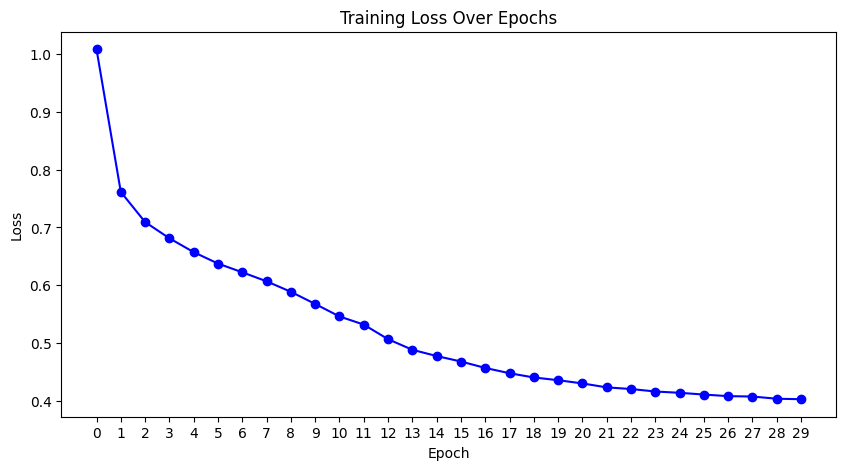

In [27]:
import matplotlib.pyplot as plt

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 5))

# Plot the train_loss
ax.plot([x/699 for x in loss_history], marker='o', linestyle='-', color='b')

# Set the title and axis labels
ax.set_title('Training Loss Over Epochs')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

# Set the x-axis ticks to be the epoch numbers
ax.set_xticks(range(len(loss_history)))

# Display the plot
plt.show()

In [28]:
!zip -r file.zip "/kaggle/working/best_model.pth"

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  adding: kaggle/working/best_model.pth^C



zip error: Interrupted (aborting)


In [29]:
from IPython.display import FileLink
FileLink(r'best_model.pth')

/kaggle/working/best_model.pth

<b> Testing the Model </b>

In [22]:
inputs = DefectDataset[1][0]

In [23]:
device = "cuda"
#model.to(device)
metadata = inputs.to(device)
outputs = model.generate(**inputs, max_length=64, min_length=20)
processor.decode(outputs[0], skip_special_tokens=True)

' '